/tmp/ipykernel_3683336/851833906.py:37: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for bars, hatch, legend_handle in zip(ax.containers, ['//', '', '', '', '', ], ax.legend_.legendHandles):


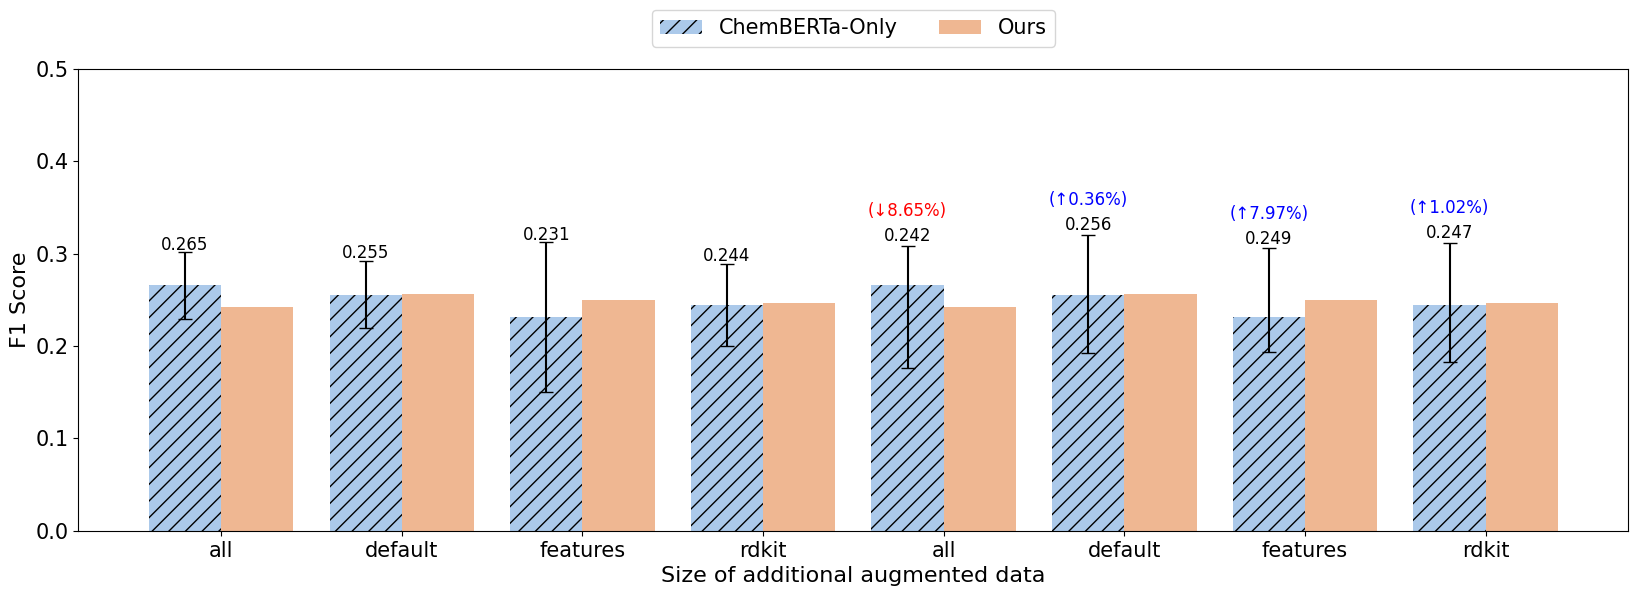

In [29]:
import os
import seaborn as sns
import matplotlib.pyplot as plt

import pandas as pd


path = f"./plot_data/baseline/"
files = f"result_metrics"
y_aim = [0.0, 0.5]
# error_aim = [3.0, 1.5, 2.5]
error_aim = 3.0

order_list = ["ChemBERTa-Only", "Ours"]

df_score = pd.read_csv(path + f"{files}.csv")
df_plotdata = df_score

# Change the color palette
sns.reset_defaults()
sns.set_palette('pastel')  # You can choose other palettes like 'deep', 'muted', 'bright', 'pastel', 'dark', 'colorblind'

df_groupdata = df_plotdata.groupby(["framework","feature_type", "model_type"]).agg(rm2_mean = ("test_rm2", "mean"), rm2_std = ("test_rm2", "std")).reset_index()
df_groupdata['framework'] = df_groupdata['framework'].astype('category')
df_groupdata['framework'] = df_groupdata['framework'].cat.set_categories(order_list)
df_groupdata = df_groupdata.sort_values(['framework', 'feature_type'])

# models = df_groupdata['feature_type'].unique()
aug_size = ["default", "features", "rdkit", "all"]
plt.figure(figsize=(20, 6))

filtered_df = df_groupdata[df_groupdata['feature_type'].isin(aug_size)]
ax = sns.barplot(x="feature_type", y="rm2_mean", hue="framework", capsize=.2, data=df_groupdata, order=list(df_groupdata["feature_type"]))

# for aug_len in aug_size:
    # df_sampled = filtered_df[df_groupdata['addition_size'] == aug_len]
for bars, hatch, legend_handle in zip(ax.containers, ['//', '', '', '', '', ], ax.legend_.legendHandles):
    for bar in bars:
        bar.set_hatch(hatch)
    # update the existing legend
    legend_handle.set_hatch(hatch + hatch)
        
x_positions = [p.get_x() + p.get_width() / 2. for p in ax.patches][:len(df_groupdata['framework'])]
zero_index = x_positions.index(0.0) if 0.0 in x_positions else len(x_positions)
x_positions = x_positions[:zero_index] 

y_means = filtered_df["rm2_mean"]
y_errors = filtered_df["rm2_std"]

ax.errorbar(x_positions, y_means, yerr=y_errors, fmt='none', capsize=5, color='black', zorder=5)
# barplot 위에 평균 값 annotation
for plot_idx, (p, y_mean, y_error) in enumerate(zip(ax.patches, y_means, y_errors)):
    if plot_idx in range(len(aug_size)):
        ax.annotate(f'{y_mean:.3f}', (p.get_x() + p.get_width() / 2., y_mean + y_error + 0.001),
                    ha='center', va='center', xytext=(0, 5), textcoords='offset points', fontsize=12)
        
    else:
        # Calculate the percentage difference from 'w/o CL'
        baseline_value = float(filtered_df[filtered_df['framework'] == "ChemBERTa-Only"]["rm2_mean"].values[plot_idx % len(aug_size)])
        percentage_difference = ((y_mean - baseline_value) / baseline_value) * 100


        # Display '↑' if there is an improvement, '↓' if there is a decrease
        sign = '↑' if percentage_difference >= 0 else '↓'
        color = 'blue' if sign == '↑' else 'red'
        ax.annotate(f'{y_mean:.3f}', (p.get_x() + p.get_width() / 2., y_mean + y_error + (0.001 *  error_aim)),
                            ha='center', va='center', xytext=(0, 5), textcoords='offset points', fontsize=12)
        
        ax.annotate(f'({sign}{abs(percentage_difference):.2f}%)',
                            (p.get_x() + p.get_width() / 2., y_mean + y_error + (0.01 *  error_aim)),
                            ha='center', va='center', xytext=(0, 5), textcoords='offset points', fontsize=12, color=color)


plt.ylim(y_aim[0], y_aim[1])
plt.xlabel('Size of additional augmented data', fontsize=16)
plt.ylabel('F1 Score', fontsize=16)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

# Place the legend above the plot
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=4, fontsize=15, title_fontsize=16)

# save_path = f"./plots/base/{model_type}_{str(samples)}/"
# if not os.path.exists(save_path):
#     os.makedirs(save_path)

# plt.savefig(save_path + f"{model_type}_{str(aug_size[0])}to{str(aug_size[-1])}.eps", format="eps")
plt.show()
    
        
    

In [24]:
import os
import pandas as pd
import numpy as np

import plotly.graph_objects as go
from plotly.subplots import make_subplots


rdkit_result_path = f"./results/1_config_sweep/rdkit_mlp_newdata_nonvivo_sort_seed2334_r2_0.131/results.csv"
feature_result_path = f"./results/1_config_sweep/features_mlp_newdata_nonvivo_sort_seed2334_r2_0.210/results.csv"
## -- predict plot save -- ##
x_axisName = ["MW_range", "PSA_range", "NRB_range", "HBA_range", "HBD_range", "LogP_range"]

MW_label = ["<200", "200-300", "300-400", "400-500", "500-600",">=600"]
PSA_label = ["<50", "50-75", "75-100", "100-150", ">=150"]
NRB_label = ["<3", "3-5", "5-7", "7-10", ">=10"]
HBA_label = ["<1", "1-3", "3-5", "5-7", "7-10", ">=10"]
HBD_label = ["<1", "1-3", "3-5", "5-7", "7-10", ">=10"]
LogP_label = ["<0", "0-1", "1-2", "2-3", "3-4",">=4"]

category_list = [MW_label, PSA_label, NRB_label, HBA_label, HBD_label, LogP_label]

df_rdkit = pd.read_csv(rdkit_result_path)
df_feature = pd.read_csv(feature_result_path)

y_labels, y_rdkit, y_feature = df_rdkit['Clint'], df_rdkit['predict'], df_feature['predict']
fig = make_subplots(rows=3, cols=2)

showlegend=True

for idx, axisName in enumerate(x_axisName):
    x_labels = df_rdkit[axisName]
    row_numb, col_numb = (idx // 2) + 1, (idx % 2) + 1
    
    fig.add_trace(go.Box(x=x_labels, y=y_labels,
                        name="Label",
                        # jitter=0.3,
                        pointpos=0.2,
                        # width=0.3,
                        boxpoints='all', # represent all points
                        marker_color='rgb(7,40,89)',
                        line_color='rgba(0,0,0,0)',
                        fillcolor= 'rgba(0,0,0,0)',
                        legendgroup=f"a",
                        showlegend=showlegend,
                        offsetgroup='a'), row=row_numb, col=col_numb)
    
    fig.add_trace(go.Box(x=x_labels, y=y_rdkit,
                        name="Trained RDkit data",
                        # jitter=0,
                        # pointpos=0,
                        # width=0.3,
                        boxpoints='all', # represent all points
                        marker_color='rgba(0,0,0,0)',
                        line_color='darkolivegreen',
                        legendgroup=f"b",
                        showlegend=showlegend,
                        offsetgroup='b'), row=row_numb, col=col_numb)
    
    fig.add_trace(go.Box(x=x_labels, y=y_feature,
                        name="Trained Feature data",
                        # jitter=0.3,
                        # pointpos=0,
                        # width=0.2,
                        boxpoints='all', # represent all points
                        marker_color='rgba(0,0,0,0)',
                        line_color='chocolate',
                        legendgroup=f"c",
                        showlegend=showlegend,
                        offsetgroup='c'), row=row_numb, col=col_numb)
        
    fig.update_xaxes(title_text=x_axisName[idx], categoryorder='array', categoryarray= category_list[idx], row=row_numb, col=col_numb, 
                     title_font=dict(size=16), 
                     tickfont=dict(size=15))
    
    fig.update_yaxes(title_text='Intrinsic CL (Log Scale)', row=row_numb, col=col_numb, 
                     title_font=dict(size=16), 
                     tickfont=dict(size=15))

    showlegend=False

fig.update_layout(
    height=1000, 
    width=1400,
    boxmode='group',
    legend=dict(orientation='h', yanchor="bottom", y=1.03, xanchor="center", x=0.5, borderwidth=1, font=dict(size=15))
)

# fig.write_image(os.path.join("../", save_path))
# fig.write_image(save_path)
# fig.write_image("Clint_prediction_distribution_feature.pdf", format="pdf")
fig.write_image("Clint_prediction_distribution.pdf", format="pdf")
fig.show()